# Chess RL Control Book

This notebook orchestrates data preparation, supervised pre-training, reinforcement learning fine-tuning, and evaluation for the chess reinforcement learning project. Enable or disable specific stages via the configuration toggles below.

## Environment Setup

In [1]:
from pathlib import Path
import json
import torch

try:
    import pandas as pd
    HAS_PANDAS = True
except ImportError:
    HAS_PANDAS = False
    print("pandas not available; tabular outputs will be simplified.")

try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except ImportError:
    HAS_MPL = False
    print("matplotlib not available; plots will be skipped.")

PROJECT_ROOT = Path.cwd()
DATA_INPUT = PROJECT_ROOT / "data" / "input"
WORKDIR = PROJECT_ROOT / "data" / "working"
MODELS_DIR = PROJECT_ROOT / "models"

DATA_INPUT.mkdir(parents=True, exist_ok=True)
WORKDIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

if HAS_MPL:
    plt.style.use("ggplot")
PROJECT_ROOT

WindowsPath('d:/UNI/REL301m/project')

## Pipeline Configuration

In [2]:
from datetime import datetime

DATASET_SLUG = "ironicninja/raw-chess-games-pgn"
RAW_PGN = DATA_INPUT / "lichess_db_standard_rated_2014-08.pgn"
VOCAB_PATH = WORKDIR / "move_vocab_4672.json"
SUPERVISED_CKPT = MODELS_DIR / "policy_model.pt"
RL_OUTPUT_DIR = MODELS_DIR / "rl"

PIPELINE_LIMIT = 200  # number of games to process; set to None for full dataset

RUN_DOWNLOAD = False
RUN_PROCESS = True
RUN_CLEAN_SPLIT = True
RUN_VOCAB = True
RUN_PRETRAIN = True
RUN_RL = True

config_snapshot = {
    "dataset": DATASET_SLUG,
    "raw_pgn": str(RAW_PGN),
    "workdir": str(WORKDIR),
    "supervised_ckpt": str(SUPERVISED_CKPT),
    "rl_output_dir": str(RL_OUTPUT_DIR),
    "limit": PIPELINE_LIMIT,
    "timestamp": datetime.utcnow().isoformat()
}
config_snapshot

{'dataset': 'ironicninja/raw-chess-games-pgn',
 'raw_pgn': 'd:\\UNI\\REL301m\\project\\data\\input\\lichess_db_standard_rated_2014-08.pgn',
 'workdir': 'd:\\UNI\\REL301m\\project\\data\\working',
 'supervised_ckpt': 'd:\\UNI\\REL301m\\project\\models\\policy_model.pt',
 'rl_output_dir': 'd:\\UNI\\REL301m\\project\\models\\rl',
 'limit': 200,
 'timestamp': '2025-10-15T11:21:08.290459'}

## Execute Selected Stages

In [3]:
from src.download_data import download_chess_data
from src.data_processing import extract_moves_from_pgn
from src.clean_split_data import clean_dataset, split_jsonl_dataset
from src.vocabulary import build_alphazero_4672
from src.train import run_supervised_training
from src.rl_training import run_rl_training, SelfPlayConfig, OptimizationConfig

rl_log_cache = None
supervised_metrics = None

if RUN_DOWNLOAD:
    download_chess_data(dataset_name=DATASET_SLUG, download_path=DATA_INPUT)

if RUN_PROCESS:
    extract_moves_from_pgn(
        path_in=RAW_PGN,
        path_out=WORKDIR / "move_dataset.jsonl",
        limit=PIPELINE_LIMIT,
    )

if RUN_CLEAN_SPLIT:
    clean_path = WORKDIR / "move_dataset_clean.jsonl"
    clean_dataset(WORKDIR / "move_dataset.jsonl", clean_path)
    split_jsonl_dataset(clean_path, WORKDIR)

if RUN_VOCAB:
    move2id, _ = build_alphazero_4672()
    with VOCAB_PATH.open("w", encoding="utf-8") as f:
        json.dump(move2id, f)
    print(f"Vocabulary saved to {VOCAB_PATH}")



c:\Users\fxlqt\.conda\envs\rel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
processing games: 200game [00:01, 152.90game/s]


[data_processing] processed 200 games -> 13357 positions written to d:\UNI\REL301m\project\data\working\move_dataset.jsonl
[clean_split] wrote cleaned dataset to d:\UNI\REL301m\project\data\working\move_dataset_clean.jsonl (kept=12799, removed=558)
[clean_split] train.jsonl: 10239 samples -> d:\UNI\REL301m\project\data\working\train.jsonl
[clean_split] val.jsonl: 1279 samples -> d:\UNI\REL301m\project\data\working\val.jsonl
[clean_split] test.jsonl: 1281 samples -> d:\UNI\REL301m\project\data\working\test.jsonl
[vocabulary] generated 4672 moves
Vocabulary saved to d:\UNI\REL301m\project\data\working\move_vocab_4672.json


In [ ]:
if RUN_PRETRAIN:
    supervised_metrics = run_supervised_training(
        workdir=WORKDIR,
        vocab_path=VOCAB_PATH,
        checkpoint_path=SUPERVISED_CKPT,
        epochs=3,
        batch_size=256,s
        lr=1e-3,
        num_workers=0,
        resume=None,
    )
    print("Supervised metrics:", supervised_metrics)

[Epoch 001] train_loss=3.1810 | val_loss=3.0058


[Epoch 002] train_loss=2.9419 | val_loss=3.0060


[Epoch 003] train_loss=2.8516 | val_loss=3.0478
Validation metrics after training: {'loss': 3.047778855831573, 'perplexity': 21.068496245949657, 'top1': 0.15715402658326819, 'top3': 0.33541829554339325}
Supervised metrics: {'loss': 3.047778855831573, 'perplexity': 21.068496245949657, 'top1': 0.15715402658326819, 'top3': 0.33541829554339325}


In [5]:
if RUN_RL:
    rl_self_play = SelfPlayConfig(
        games_per_iteration=8,
        max_moves=140,
        temperature=1.0,
        random_move_prob=0.05,
        gamma=0.99,
    )
    rl_optim = OptimizationConfig(
        num_iterations=5,
        policy_epochs=2,
        batch_size=128,
        lr=5e-4,
        entropy_coef=0.01,
        value_coef=0.5,
        save_interval=5,
    )
    import io
    import contextlib

    buffer = io.StringIO()
    with contextlib.redirect_stdout(buffer):
        run_rl_training(
            vocab_path=VOCAB_PATH,
            supervised_checkpoint=SUPERVISED_CKPT,
            output_dir=RL_OUTPUT_DIR,
            resume=None,
            self_play_cfg=rl_self_play,
            optim_cfg=rl_optim,
        )
    rl_log_cache = buffer.getvalue()
    preview = "\n".join(rl_log_cache.splitlines()[:5])
    if preview:
        print(preview)
    else:
        print("RL training completed with no captured log output.")

Loaded 3 tensors from supervised checkpoint.
Skipped 19 tensors due to shape mismatch: first few -> ['backbone.trunk.0.weight', 'backbone.trunk.1.weight', 'backbone.trunk.1.bias', 'backbone.trunk.1.running_mean', 'backbone.trunk.1.running_var']
Loaded supervised weights from d:\UNI\REL301m\project\models\policy_model.pt
[Iter 001] loss=nan policy=-0.03165 value=0.00152 entropy=nan avg_return=0.000 win_rate=0.00% draw_rate=100.00% avg_length=140.0
[Iter 002] loss=nan policy=0.06612 value=0.00152 entropy=nan avg_return=0.000 win_rate=0.00% draw_rate=100.00% avg_length=140.0


## RL Training Log Parsing

,iteration,loss,policy_loss,value_loss,entropy,avg_return,win_rate,draw_rate,avg_length
0,1,NaN,-0.03165,0.00152,NaN,0.0,0.0,1.0,140.0
1,2,NaN,0.06612,0.00152,NaN,0.0,0.0,1.0,140.0
2,3,NaN,-0.00216,0.00152,NaN,0.0,0.0,1.0,140.0
3,4,NaN,0.02163,0.00151,NaN,0.0,0.0,1.0,140.0
4,5,NaN,0.01836,0.00152,NaN,0.0,0.0,1.0,140.0


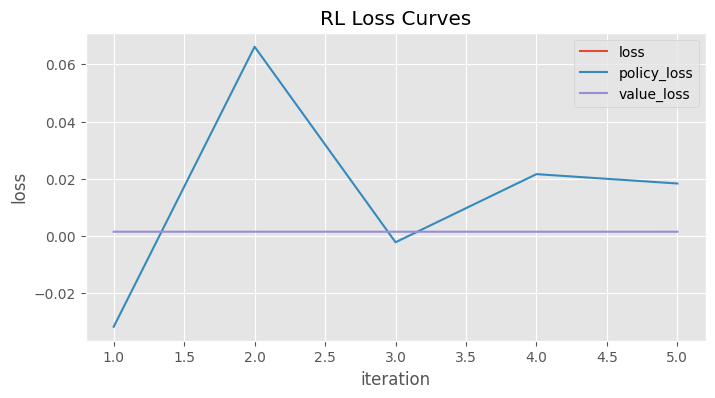

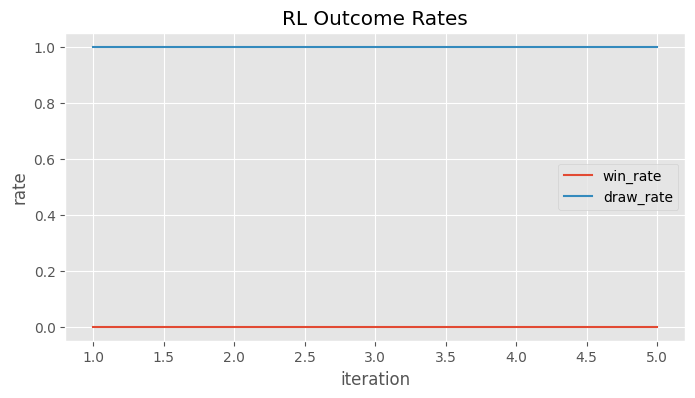

In [6]:
import re

def parse_rl_log(log_text: str):
    pattern = re.compile(
        r"\[Iter\s+(\d+)\].*?loss=(\S+).*?policy=(\S+).*?value=(\S+).*?entropy=(\S+).*?avg_return=([\-\d\.]+).*?win_rate=(\d+\.\d+)%.*?draw_rate=(\d+\.\d+)%.*?avg_length=(\d+\.\d+)"
    )
    rows = []
    for match in pattern.finditer(log_text):
        rows.append({
            "iteration": int(match.group(1)),
            "loss": float(match.group(2)),
            "policy_loss": float(match.group(3)),
            "value_loss": float(match.group(4)),
            "entropy": float(match.group(5)),
            "avg_return": float(match.group(6)),
            "win_rate": float(match.group(7)) / 100.0,
            "draw_rate": float(match.group(8)) / 100.0,
            "avg_length": float(match.group(9)),
        })
    return rows

if rl_log_cache:
    rl_rows = parse_rl_log(rl_log_cache)
    if rl_rows:
        if HAS_PANDAS:
            df_rl = pd.DataFrame(rl_rows)
            display(df_rl)
            if HAS_MPL:
                ax = df_rl.plot(x="iteration", y=["loss", "policy_loss", "value_loss"], figsize=(8, 4), title="RL Loss Curves")
                ax.set_ylabel("loss")
                plt.show()
                ax = df_rl.plot(x="iteration", y=["win_rate", "draw_rate"], figsize=(8, 4), title="RL Outcome Rates")
                ax.set_ylabel("rate")
                plt.show()
        else:
            print("Parsed RL metrics:")
            for row in rl_rows:
                print(f"Iter {row['iteration']}: loss={row['loss']:.4f}, win_rate={row['win_rate']:.2%}, avg_len={row['avg_length']:.1f}")
            if not HAS_MPL:
                print("matplotlib not available; skipping plots.")
    else:
        print("No RL iterations parsed from the log.")
else:
    print("RL log cache is empty. Enable RUN_RL above to capture logs.")

## Supervised Metrics

In [7]:
if supervised_metrics:
    if HAS_PANDAS:
        display(pd.DataFrame([supervised_metrics]))
    else:
        print("Supervised metrics:", supervised_metrics)
else:
    print("No supervised training metrics captured. Enable RUN_PRETRAIN above.")

,loss,perplexity,top1,top3
0,3.047779,21.068496,0.157154,0.335418


## Inspect Checkpoints

In [8]:
from pprint import pprint

print("Supervised checkpoint available:", SUPERVISED_CKPT.exists())
if SUPERVISED_CKPT.exists():
    size_mb = SUPERVISED_CKPT.stat().st_size / 1e6
    print(f" - {SUPERVISED_CKPT.name}: {size_mb:.2f} MB")

if RL_OUTPUT_DIR.exists():
    rl_files = sorted(RL_OUTPUT_DIR.glob("*.pt"))
    print("RL checkpoints:")
    if rl_files:
        for f in rl_files:
            print(f" - {f.name} ({f.stat().st_size / 1e6:.2f} MB)")
    else:
        print(" - No RL checkpoints found in directory.")
else:
    print("RL output directory not found.")

Supervised checkpoint available: True
 - policy_model.pt: 162.07 MB
RL checkpoints:
 - policy_value_final.pt (198.46 MB)
 - policy_value_iter_005.pt (198.46 MB)


## Prediction Playground

In [9]:
from src.predict import predict_move, load_checkpoint
from src.models import PolicyNet

sample_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
TOP_K = 5

if SUPERVISED_CKPT.exists():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = load_checkpoint(SUPERVISED_CKPT, device)
    move2id = checkpoint["vocab"]
    model = PolicyNet(len(move2id))
    model.load_state_dict(checkpoint["model_state"])
    model.to(device)
    moves = predict_move(sample_fen, model, move2id, device, topk=TOP_K)
    print("Top moves:", moves)
else:
    print("Supervised checkpoint not found. Run pretraining first.")

Top moves: ['g1f3', 'd2d4', 'e2e3', 'b1c3', 'd2d3']


d:\UNI\REL301m\project\src\predict.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)
